## Install Packages

In [144]:
!pip install kneed
!pip install umap-learn matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load Packages

In [145]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap

## Load Data

In [146]:
df = pd.read_csv("/content/taxonomic_profiles.tsv", sep="\t")

## Pre-Process

### Set 'Taxonomy' Column as Index

In [147]:
df = df.set_index("taxonomy")

### Transpose

In [148]:
df = df.transpose()

In [149]:
# Drop the first row (OTU ID)
df.drop(df.index[0], inplace=True)

In [150]:
df.head()

taxonomy,Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rhodospirillales; __Acetobacteraceae; __Belnapia,Bacteria; __Proteobacteria; __Betaproteobacteria; __Burkholderiales; __Comamonadaceae; __Tepidimonas,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Christensenellaceae; __Christensenellaceae_R_7_group,Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Prevotellaceae; __Prevotella,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Family_XIII; __Family_XIII_AD3011_group,Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rhodobacterales; __Rhodobacteraceae; __Paracoccus,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminiclostridium,Bacteria; __Proteobacteria; __Gammaproteobacteria; __Run_SP154; __f; __g,Bacteria; __Proteobacteria; __Gammaproteobacteria; __Pasteurellales; __Pasteurellaceae; __Frederiksenia,Bacteria; __Actinobacteria; __Actinobacteria; __Corynebacteriales; __Corynebacteriaceae; __Corynebacterium_1,...,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Clostridiales_vadinBB60_group; __g,Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Prevotellaceae; __Prevotella,Bacteria; __Tenericutes; __Mollicutes; __Mollicutes_RF9; __f; __g,Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rhodospirillales; __Rhodospirillales_Incertae_Sedis; __Candidatus_Alysiosphaera,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminococcus_1,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Blautia,Bacteria; __Bacteroidetes; __Sphingobacteriia; __Sphingobacteriales; __Saprospiraceae; __uncultured,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Roseburia,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __uncultured,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminococcaceae_UCG_014
206646,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,481.0,0.0,0.0,0.0,0.0
224324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0
206619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
224326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
206624,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Relative Abundance Normalization

In [151]:
def normalize(row):
    total = row.sum()
    return row / total

df = df.apply(normalize, axis=1)

In [152]:
df.head()

taxonomy,Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rhodospirillales; __Acetobacteraceae; __Belnapia,Bacteria; __Proteobacteria; __Betaproteobacteria; __Burkholderiales; __Comamonadaceae; __Tepidimonas,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Christensenellaceae; __Christensenellaceae_R_7_group,Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Prevotellaceae; __Prevotella,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Family_XIII; __Family_XIII_AD3011_group,Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rhodobacterales; __Rhodobacteraceae; __Paracoccus,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminiclostridium,Bacteria; __Proteobacteria; __Gammaproteobacteria; __Run_SP154; __f; __g,Bacteria; __Proteobacteria; __Gammaproteobacteria; __Pasteurellales; __Pasteurellaceae; __Frederiksenia,Bacteria; __Actinobacteria; __Actinobacteria; __Corynebacteriales; __Corynebacteriaceae; __Corynebacterium_1,...,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Clostridiales_vadinBB60_group; __g,Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Prevotellaceae; __Prevotella,Bacteria; __Tenericutes; __Mollicutes; __Mollicutes_RF9; __f; __g,Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rhodospirillales; __Rhodospirillales_Incertae_Sedis; __Candidatus_Alysiosphaera,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminococcus_1,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Blautia,Bacteria; __Bacteroidetes; __Sphingobacteriia; __Sphingobacteriales; __Saprospiraceae; __uncultured,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Roseburia,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __uncultured,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminococcaceae_UCG_014
206646,0.000000,0.0,0.0,0.0,0.000042,0.0,0.000085,0.0,0.0,0.000339,...,0.0,0.0,0.0,0.0,0.0,0.020375,0.0,0.0,0.0,0.0
224324,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000689,0.0,0.0,0.0,0.0
206619,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.001242,0.0,0.0,0.0,0.0
224326,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.003918,0.0,0.0,0.0,0.0
206624,0.023743,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


### Keep One Duplicate Column Only

In [153]:
if df.columns.duplicated().any():
    print("There are duplicate column names in the dataframe")
else:
    print("There are no duplicate column names in the dataframe")

There are duplicate column names in the dataframe


In [154]:
df = df.loc[:, ~df.columns.duplicated()]

## Save Pre-Processed to CSV

In [155]:
#df.to_csv('/content/pre_processed_data.csv', index=False)

In [156]:
#df = pd.read_csv("/content/pre_processed_data.csv")

In [157]:
if df.columns.duplicated().any():
    print("There are duplicate column names in the dataframe")
else:
    print("There are no duplicate column names in the dataframe")

There are no duplicate column names in the dataframe


In [158]:
print(df.shape)

(178, 476)


## K-Means Clustering

### Determine the Optimal Number of Clusters

#### Elbow Plot

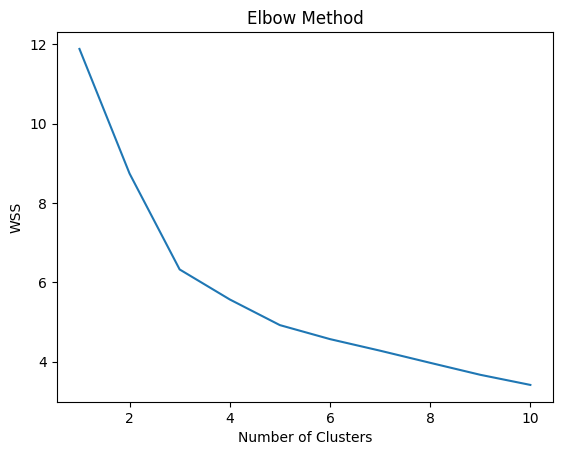

In [159]:
wss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    wss.append(kmeans.inertia_)
plt.plot(range(1, 11), wss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS')
plt.show()

In [160]:
kl = KneeLocator(range(1, 11), wss, curve="convex", direction="decreasing")
kl.elbow

3

#### Silhouette Coefficient

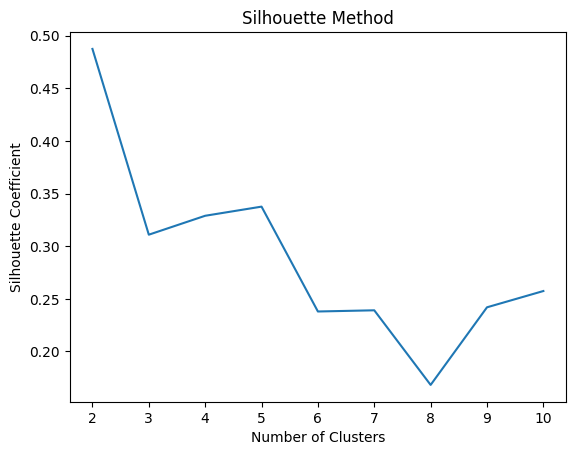

In [161]:
silhouette_coefficients = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    score = silhouette_score(df, kmeans.labels_)
    silhouette_coefficients.append(score)
plt.plot(range(2, 11), silhouette_coefficients)
plt.title('Silhouette Method')
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Choose k = 3

### K-Means Modeling

In [162]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(df)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=0)

In [163]:
labels = kmeans.labels_
df['cluster'] = labels

### Plot Using PCA

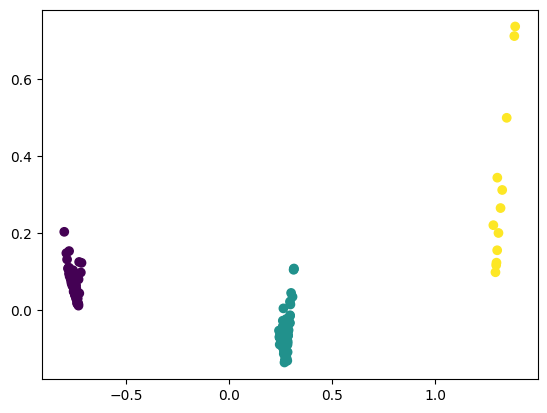

In [164]:
pca = PCA(n_components=2)
pca.fit(df)
transformed = pca.transform(df)

# plot the data points with different colors for each cluster
plt.scatter(transformed[:, 0], transformed[:, 1], c=labels)
plt.show()

### Internal Validation

In [165]:
# compute the Silhouette score
silhouette_avg = silhouette_score(df, labels)

# compute the Davies-Bouldin index
davies_bouldin_idx = davies_bouldin_score(df, labels)

# compute the Calinski-Harabasz index
calinski_harabasz_idx = calinski_harabasz_score(df, labels)

print(f'Silhouette score: {silhouette_avg:.3f}')
print(f'Davies-Bouldin index: {davies_bouldin_idx:.3f}')
print(f'Calinski-Harabasz index: {calinski_harabasz_idx:.3f}')

Silhouette score: 0.781
Davies-Bouldin index: 0.339
Calinski-Harabasz index: 887.338


### Feature Importances

In [166]:
feature_names = df.drop(columns=['cluster']).columns 

centroids = kmeans.cluster_centers_
differences = []
for i in range(num_clusters):
    for j in range(i+1, num_clusters):
        diff = np.abs(centroids[i] - centroids[j])
        differences.append(diff)
differences = np.array(differences)
feature_importance = pd.DataFrame(differences.sum(axis=0), columns=['importance'], index=feature_names)
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
feature_importance = feature_importance.loc[~feature_importance.index.duplicated(keep='first')]
print(feature_importance)

                                                    importance
taxonomy                                                      
Bacteria; __Proteobacteria; __Gammaproteobacter...    1.031693
Bacteria; __Bacteroidetes; __Bacteroidia; __Bac...    0.591894
Bacteria; __Firmicutes; __Clostridia; __Clostri...    0.096494
Bacteria; __Proteobacteria; __Betaproteobacteri...    0.059451
Bacteria; __Firmicutes; __Clostridia; __Clostri...    0.041921
...                                                        ...
Bacteria; __Nitrospirae; __Nitrospira; __Nitros...    0.000000
Bacteria; __Bacteroidetes; __Cytophagia; __Cyto...    0.000000
Bacteria; __Actinobacteria; __Actinobacteria; _...    0.000000
Bacteria; __Actinobacteria; __Actinobacteria; _...    0.000000
Bacteria; __Cyanobacteria; __ML635J_21; __o; __...    0.000000

[476 rows x 1 columns]


In [167]:
print(feature_importance.index[0:5])

Index(['Bacteria; __Proteobacteria; __Gammaproteobacteria; __Enterobacteriales; __Enterobacteriaceae; __Escherichia_Shigella',
       'Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Bacteroidaceae; __Bacteroides',
       'Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Eubacterium_rectale_group',
       'Bacteria; __Proteobacteria; __Betaproteobacteria; __Burkholderiales; __Oxalobacteraceae; __Massilia',
       'Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Anaerostipes'],
      dtype='object', name='taxonomy')


## Visualization

### Box Plots

#### Escherichia_Shigella

Text(0.5, 1.0, 'Distribution of Escherichia_Shigella by Cluster')

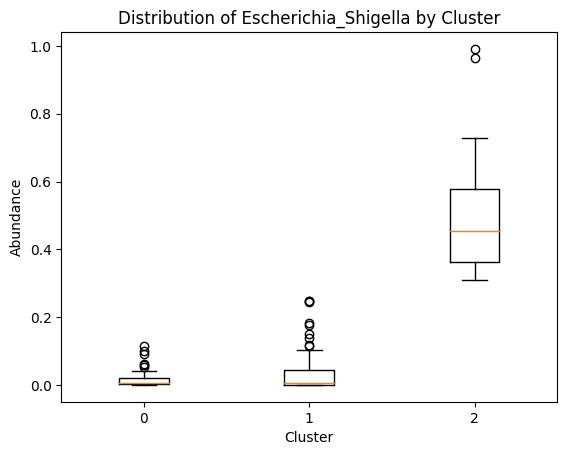

In [168]:
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Proteobacteria; __Gammaproteobacteria; __Enterobacteriales; __Enterobacteriaceae; __Escherichia_Shigella'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Escherichia_Shigella by Cluster')

#### Bacteroides

Text(0.5, 1.0, 'Distribution of Bacteroides by Cluster')

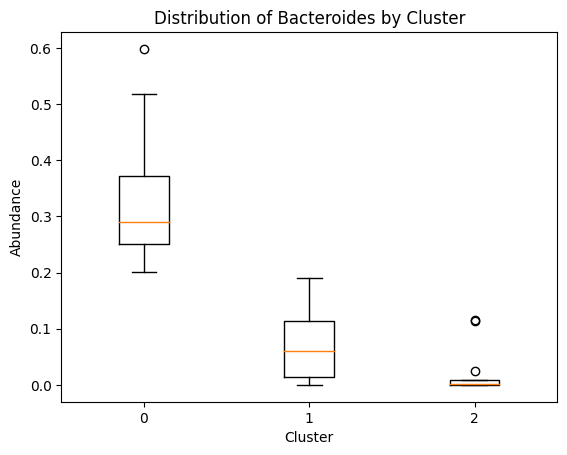

In [169]:
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Bacteroidaceae; __Bacteroides'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Bacteroides by Cluster')

#### Eubacterium_rectale_group

Text(0.5, 1.0, 'Distribution of Eubacterium_rectale_group by Cluster')

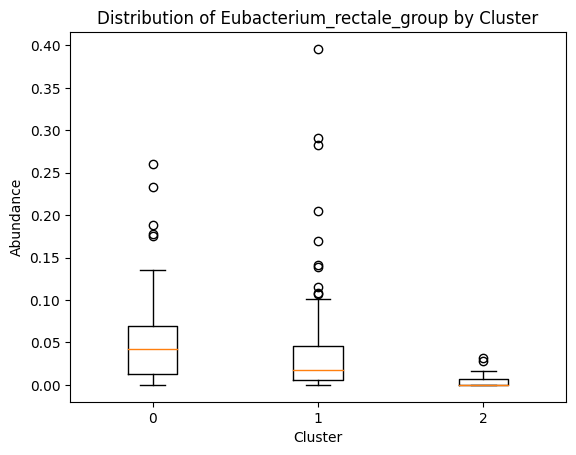

In [170]:
# Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Eubacterium_rectale_group
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Eubacterium_rectale_group'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Eubacterium_rectale_group by Cluster')

#### Oxalobacteraceae; __Massilia

Text(0.5, 1.0, 'Distribution of Oxalobacteraceae; __Massilia by Cluster')

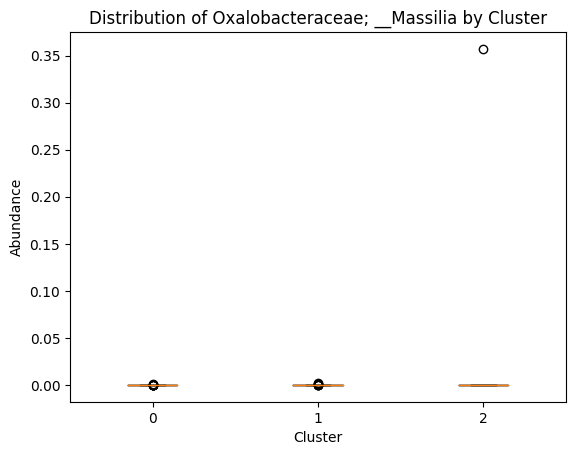

In [171]:
# Bacteria; __Proteobacteria; __Betaproteobacteria; __Burkholderiales; __Oxalobacteraceae; __Massilia
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Proteobacteria; __Betaproteobacteria; __Burkholderiales; __Oxalobacteraceae; __Massilia'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Oxalobacteraceae; __Massilia by Cluster')

#### Anaerostipes

Text(0.5, 1.0, 'Distribution of Anaerostipes by Cluster')

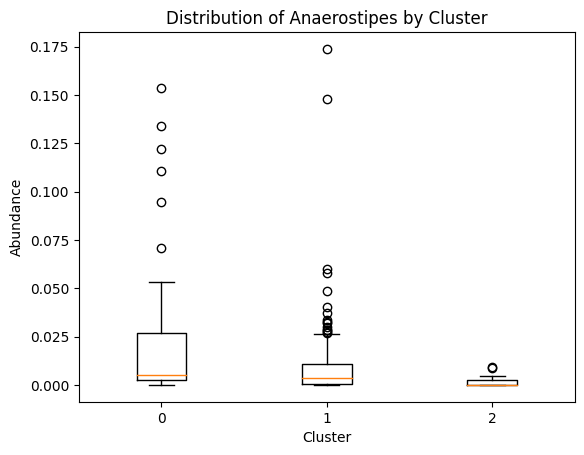

In [172]:
# Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Anaerostipes
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Anaerostipes'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Anaerostipes by Cluster')

#### Roseburia

Text(0.5, 1.0, 'Distribution of Oxalobacteraceae; __Massilia by Cluster')

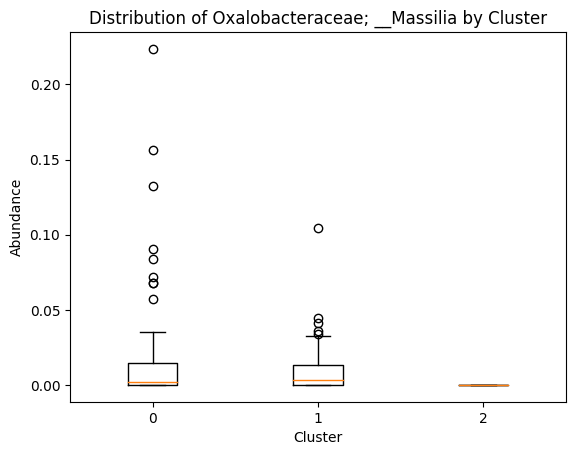

In [173]:
# Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Roseburia
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Roseburia'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Oxalobacteraceae; __Massilia by Cluster')

## UMAP

### Plotting

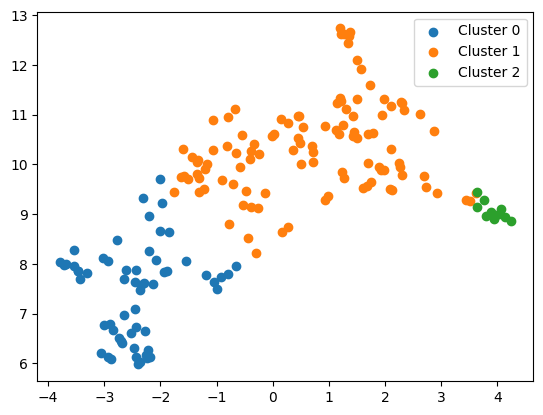

In [179]:
cluster_labels = df['cluster'].values
df_umap = df.drop(columns=['cluster'])

# Reduce dimensionality with UMAP
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(df_umap)

# Create a scatter plot with colored points
unique_labels = np.unique(cluster_labels)
for label in unique_labels:
    plt.scatter(embedding[cluster_labels == label, 0], 
                embedding[cluster_labels == label, 1], 
                label='Cluster {}'.format(label))

# Add a legend to show the cluster labels
plt.legend()

# Show the plot
plt.show()

### Feature Importance

In [197]:
corr_matrix = np.corrcoef(df_umap.T, embedding.T)
# print(len(corr_matrix))
importance_scores = np.abs(corr_matrix[:-2, -2:])
# print(len(importance_scores))
feature_names = df_umap.columns
# print(len(feature_names))
feature_importance = pd.DataFrame(importance_scores.T, columns=feature_names[:-2])
feature_ranking = feature_importance.mean().sort_values(ascending=False)
print(feature_ranking)

taxonomy
Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Bacteroidaceae; __Bacteroides                              0.829801
Bacteria; __Proteobacteria; __Gammaproteobacteria; __Enterobacteriales; __Enterobacteriaceae; __Escherichia_Shigella    0.300561
Bacteria; __Verrucomicrobia; __Verrucomicrobiae; __Verrucomicrobiales; __Verrucomicrobiaceae; __Akkermansia             0.268440
Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminococcaceae_UCG_005                     0.262451
Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Ruminococcus_gnavus_group                  0.213766
                                                                                                                          ...   
Bacteria; __Actinobacteria; __Actinobacteria; __Micrococcales; __Micrococcaceae; __Enteractinococcus                         NaN
Bacteria; __Proteobacteria; __Betaproteobacteria; __Neisseriales; __Neisseriaceae; __Vog

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [214]:
print(feature_ranking.index[4])

Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Ruminococcus_gnavus_group


#### Bacteroides

Text(0.5, 1.0, 'Distribution of Bacteroides by Cluster')

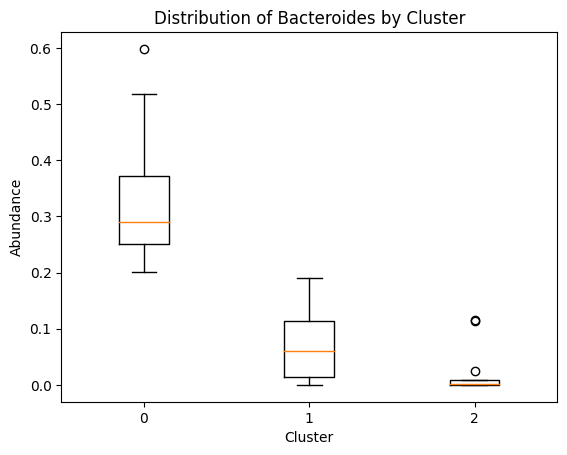

In [198]:
# Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Bacteroidaceae; __Bacteroides
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Bacteroidaceae; __Bacteroides'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Bacteroides by Cluster')

#### Escherichia_Shigella

Text(0.5, 1.0, 'Distribution of Escherichia_Shigella by Cluster')

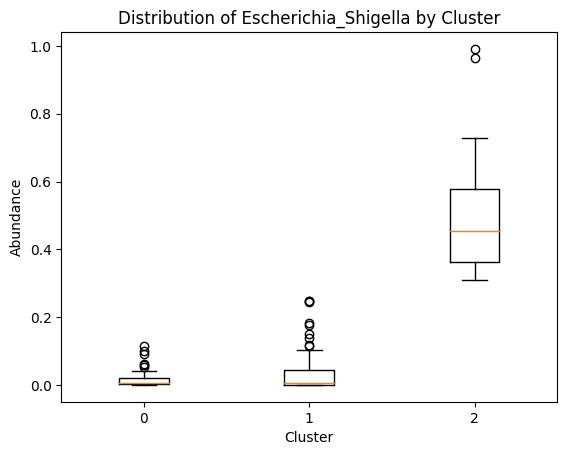

In [199]:
# Bacteria; __Proteobacteria; __Gammaproteobacteria; __Enterobacteriales; __Enterobacteriaceae; __Escherichia_Shigella
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Proteobacteria; __Gammaproteobacteria; __Enterobacteriales; __Enterobacteriaceae; __Escherichia_Shigella'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Escherichia_Shigella by Cluster')

#### Akkermansia 

Text(0.5, 1.0, 'Distribution of Akkermansia  by Cluster')

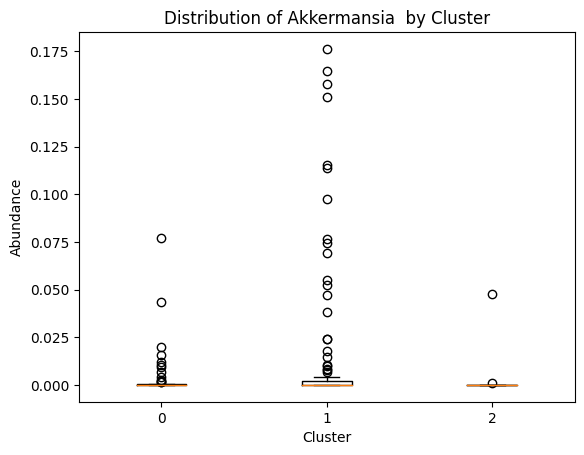

In [211]:
# Bacteria; __Verrucomicrobia; __Verrucomicrobiae; __Verrucomicrobiales; __Verrucomicrobiaceae; __Akkermansia
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Verrucomicrobia; __Verrucomicrobiae; __Verrucomicrobiales; __Verrucomicrobiaceae; __Akkermansia'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Akkermansia  by Cluster')

#### Ruminococcaceae_UCG_005


Text(0.5, 1.0, 'Distribution of Ruminococcaceae_UCG_005  by Cluster')

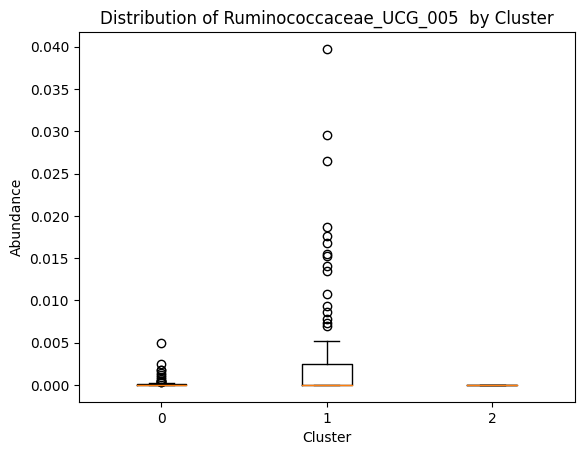

In [213]:
# Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminococcaceae_UCG_005
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminococcaceae_UCG_005'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Ruminococcaceae_UCG_005  by Cluster')

#### Ruminococcus_gnavus_group

Text(0.5, 1.0, 'Distribution of Ruminococcus_gnavus_group by Cluster')

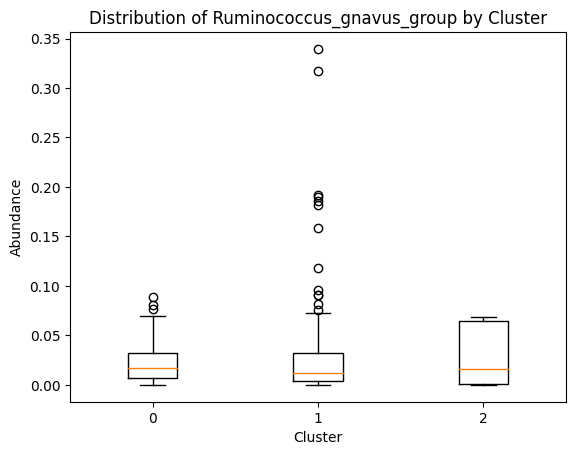

In [215]:
# Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Ruminococcus_gnavus_group
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Ruminococcus_gnavus_group'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Ruminococcus_gnavus_group by Cluster')